# Neural Networks

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Set random seeds
np.random.seed(0)
torch.manual_seed(0)
os.environ['PYTHONHASHSEED'] = str(0)

In [116]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class FullyConnected(nn.Module):
         
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 2 * in_features, bias=True),
            nn.ReLU(),
            nn.Linear(2 * in_features, 2 * in_features, bias=True),
            nn.ReLU(),
            nn.Linear(2 * in_features, in_features, bias=True),
            nn.ReLU(),
            nn.Linear(in_features, num_classes)
        )
        self.model.apply(init_weights)
        
    def forward(self, X):
        return self.model(X)

In [117]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [118]:
# Define hyperparam
hyperparam = {
    "batch_size": 64,
    "lr": 1e-3,
    "weight_decay": 1e-3
}

In [119]:
# Prepare data

df = np.array(pd.read_csv("fetal_health.csv"), dtype=np.float32)
np.random.shuffle(df)
X = np.array(df[:, :-1])
y = np.array(df[:, -1], dtype=np.int64) - 1 # We subtract 1 to make classes 0,1,2 instead of 1,2,3
num_data = len(y)
num_train = int(np.floor(num_data * 0.6))
num_val = int(np.floor(num_data * 0.2))

train_X = X[:num_train]
train_y = y[:num_train]

val_X = X[num_train:num_train + num_val]
val_y = y[num_train:num_train + num_val]

test_X = X[num_train + num_val:]
test_y = y[num_train + num_val:]

train_dataset = TabularDataset(train_X, train_y)
val_dataset = TabularDataset(val_X, val_y)
test_dataset = TabularDataset(test_X, test_y)

train_loader = DataLoader(train_dataset, batch_size=hyperparam["batch_size"], shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparam["batch_size"], shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=hyperparam["batch_size"], shuffle=True, drop_last=True)

In [120]:
model = FullyConnected(train_X.shape[1], len(np.unique(y)))

In [121]:
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), hyperparam["lr"], weight_decay=hyperparam["weight_decay"])
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99) 
num_epochs = 100

In [122]:
def predict(model, dataloader):
    num_correct = 0
    num_total = 0
    with torch.no_grad():
        for i, data in enumerate(train_loader):
            # Unpack data
            batch_X, batch_y = data

            # Perform forward pass
            pred = model(batch_X)
            
            num_correct += (torch.argmax(out, dim=1) == batch_y).int().sum()
            num_total += len(batch_y)
    return num_correct / num_total
    

In [123]:
# Training loop

losses = []
train_accuracies = []
val_accuracies = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # Unpack data
        batch_X, batch_y = data
        
        # Zero previous grad
        optimizer.zero_grad()
        
        # Perform forward pass
        out = model(batch_X)
        loss = loss_criterion(out, batch_y)
        
        # Perform backward pass
        loss.backward()
        
        # Update learning rate
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            average_loss = running_loss / 10
            losses.append(average_loss)
            running_loss = 0.0
            
            with torch.no_grad():
                acc = torch.mean((torch.argmax(out, dim=1) == batch_y).float())
                train_accuracies.append(acc)
            print(f'[Epoch {epoch + 1}, Iteration {i + 1}] loss: {average_loss} train_accuracy: {acc}')
    with torch.no_grad():
        acc = predict(model, val_loader)
        val_accuracies.append(acc)
        print(f'[Epoch {epoch + 1}] val_accuracy: {acc}')

[Epoch 1, Iteration 10] loss: 16.97059783935547 train_accuracy: 0.796875
[Epoch 1] val_accuracy: 0.4819079041481018
[Epoch 2, Iteration 10] loss: 2.3964971899986267 train_accuracy: 0.75
[Epoch 2] val_accuracy: 0.7425987124443054
[Epoch 3, Iteration 10] loss: 0.9145056962966919 train_accuracy: 0.84375
[Epoch 3] val_accuracy: 0.6192434430122375
[Epoch 4, Iteration 10] loss: 0.6234276264905929 train_accuracy: 0.796875
[Epoch 4] val_accuracy: 0.6077302694320679
[Epoch 5, Iteration 10] loss: 0.4990267068147659 train_accuracy: 0.8125
[Epoch 5] val_accuracy: 0.5657894611358643
[Epoch 6, Iteration 10] loss: 0.5609512031078339 train_accuracy: 0.734375
[Epoch 6] val_accuracy: 0.6241776347160339
[Epoch 7, Iteration 10] loss: 0.549470666050911 train_accuracy: 0.765625
[Epoch 7] val_accuracy: 0.7360197305679321
[Epoch 8, Iteration 10] loss: 0.3920339569449425 train_accuracy: 0.953125
[Epoch 8] val_accuracy: 0.6101973652839661
[Epoch 9, Iteration 10] loss: 0.4193065583705902 train_accuracy: 0.828125

[Epoch 77] val_accuracy: 0.6537829041481018
[Epoch 78, Iteration 10] loss: 0.3152256593108177 train_accuracy: 0.875
[Epoch 78] val_accuracy: 0.7228618264198303
[Epoch 79, Iteration 10] loss: 0.2632416546344757 train_accuracy: 0.875
[Epoch 79] val_accuracy: 0.6027960777282715
[Epoch 80, Iteration 10] loss: 0.2654913827776909 train_accuracy: 0.90625
[Epoch 80] val_accuracy: 0.6603618264198303
[Epoch 81, Iteration 10] loss: 0.23259664028882981 train_accuracy: 0.96875
[Epoch 81] val_accuracy: 0.6019737124443054
[Epoch 82, Iteration 10] loss: 0.27455521672964095 train_accuracy: 0.953125
[Epoch 82] val_accuracy: 0.6472039222717285
[Epoch 83, Iteration 10] loss: 0.2840127721428871 train_accuracy: 0.921875
[Epoch 83] val_accuracy: 0.6472039222717285
[Epoch 84, Iteration 10] loss: 0.27574772089719773 train_accuracy: 0.890625
[Epoch 84] val_accuracy: 0.6496710777282715
[Epoch 85, Iteration 10] loss: 0.31081463396549225 train_accuracy: 0.890625
[Epoch 85] val_accuracy: 0.6513158082962036
[Epoch 8

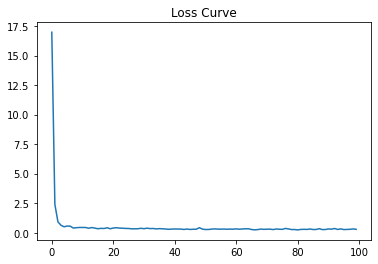

In [124]:
plt.plot(losses)
plt.title("Loss Curve")
plt.show()

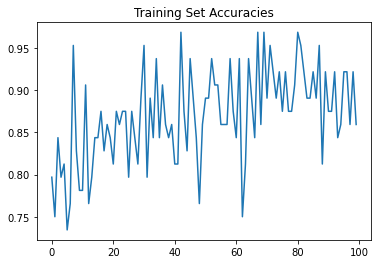

In [125]:
plt.plot(train_accuracies)
plt.title("Training Set Accuracies")
plt.show()

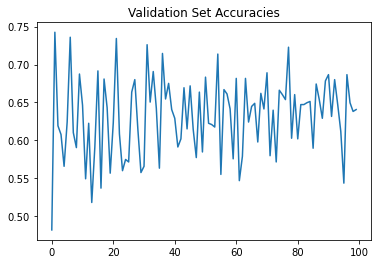

In [126]:
plt.plot(val_accuracies)
plt.title("Validation Set Accuracies")
plt.show()